In [2]:
import torch
import torch.nn as nn
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from typing import Tuple, Dict, List 
from torch.utils.data import Dataset
# from torchinfo import summary
# from torch.utils.tensorboard import SummaryWriter
from collections import OrderedDict

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import zipfile
from pathlib import Path

import os
import random
from PIL import Image

from math import ceil

In [160]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_labels = ["cat","dog","snake"]
        self.img_dir = img_dir
        self.image_paths = []
        for dirpath, dirnames, filenames in os.walk(self.img_dir):
            temp = Path(dirpath)
            for f in filenames:
                self.image_paths.append(os.path.join(temp, f))
        random.shuffle(self.image_paths)
#         print(self.image_paths)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)
    
    
    def read_image(self, img_path):
        return Image.open(img_path)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = self.read_image(img_path)
#         labels = ["cats","dogs","snakes"]
        label = os.path.split(img_path)[1].split("_")[0]
        if(label == "0"):
            label = 0
        elif(label == "1"):
            label = 1
        elif(label == "2"):
            label = 2
        
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [162]:
data_transform = v2.Compose([
    v2.Resize(size=(128,128)),
    v2.ToTensor()
])
train_dataset = CustomImageDataset("animal_dataset/train", transform=data_transform)
validation_dataset = CustomImageDataset("animal_dataset/validation", transform=data_transform)
test_dataset = CustomImageDataset("animal_dataset/test", transform=data_transform)

torch.Size([3, 128, 128]) 2


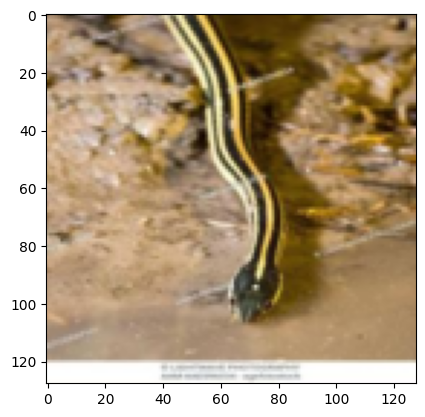

Label: 2


In [163]:
train_feature, train_label = next(iter(train_dataset))
print(train_feature.shape, train_label)
plt.imshow(train_feature.permute(1,2,0), cmap="gray")
plt.show()
print(f"Label: {train_label}")

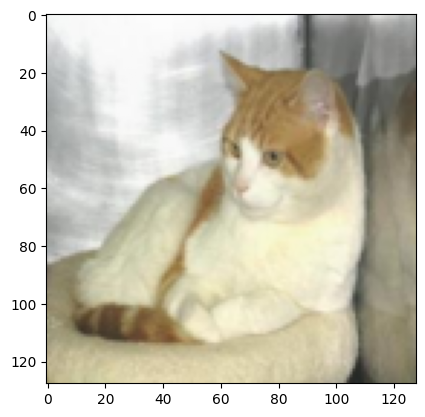

Label: 0


In [164]:
train_features = []
train_labels = []
itr = iter(train_dataset)
for i in range(64):
    train_feature, train_label = next(itr)
    train_features.append(train_feature)
    train_labels.append(train_label)

img = train_features[5].squeeze()
label = train_labels[5]
plt.imshow(img.permute(1,2,0), cmap="gray")
plt.show()
print(f"Label: {label}")

## VGG-16 module

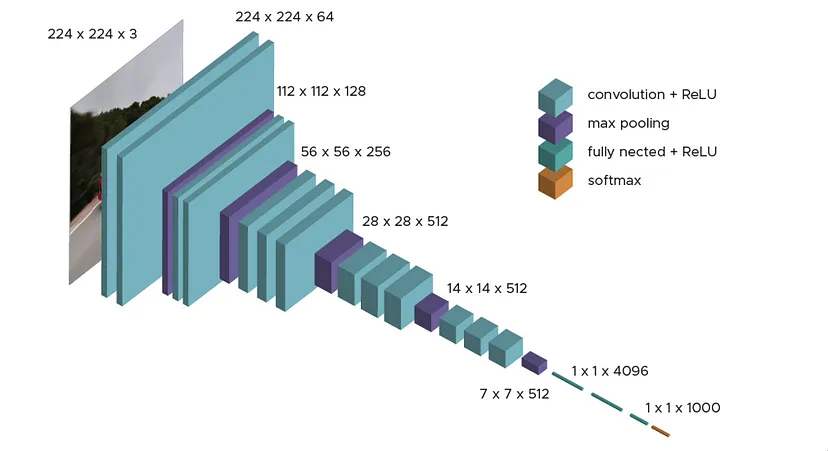

In [70]:
Image.open("./just_images/vgg-16.webp")

In [80]:
to_print = True

In [165]:
class VGG16(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG16, self).__init__()
        
        ## two layers
        self.layer1 = nn.Sequential( # 128x128x3 --> 128x128x64 ... widthxheightxnum_channels
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64), # takes num_channels
            nn.ReLU())
        
        self.layer2 = nn.Sequential( # 128x128x64 --> 64x64x64 ... widthxheightxnum_channels
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64), # takes num_channels
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        ## two layers
        self.layer3 = nn.Sequential( # 64x64x64 --> 64x64x128 ... widthxheightxnum_channels
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        
        self.layer4 = nn.Sequential( # 64x64x128 --> 32x32x128 ... widthxheightxnum_channels
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        ## three layers
        self.layer5 = nn.Sequential( # 32x32x128 --> 32x32x256 ... widthxheightxnum_channels
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        
        
        self.layer6 = nn.Sequential( # 32x32x256 --> 32x32x256 ... widthxheightxnum_channels
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        
        
        self.layer7 = nn.Sequential( # 32x32x256 --> 16x16x256 ... widthxheightxnum_channels
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        ### three layers
        self.layer8 = nn.Sequential( # 16x16x256 --> 16x16x512 ... widthxheightxnum_channels
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.layer9 = nn.Sequential( # 16x16x512 --> 16x16x512 ... widthxheightxnum_channels
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.layer10 = nn.Sequential( # 16x16x512 --> 8x8x512 ... widthxheightxnum_channels
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        ### three layers
        self.layer11 = nn.Sequential( # 8x8x512 --> 8x8x512 ... widthxheightxnum_channels
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.layer12 = nn.Sequential( # 8x8x512 --> 8x8x512 ... widthxheightxnum_channels
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.layer13 = nn.Sequential( # 8x8x512 --> 4x4x512 ... widthxheightxnum_channels
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        ### dropout
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4*4*512, 4096),
            nn.ReLU())
        
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
        
    def forward(self, x):
        if to_print:
            print("shape of x: ",x.shape)
        out = self.layer1(x)
        if to_print:
            print("shape of x after layer1: ",out.shape)
        out = self.layer2(out)
        if to_print:
            print("shape of x after layer2: ",out.shape)
        out = self.layer3(out)
        if to_print:
            print("shape of x after layer3: ",out.shape)
        out = self.layer4(out)
        if to_print:
            print("shape of x after layer4: ",out.shape)
        out = self.layer5(out)
        if to_print:
            print("shape of x after layer5: ",out.shape)
        out = self.layer6(out)
        if to_print:
            print("shape of x after layer6: ",out.shape)
        out = self.layer7(out)
        if to_print:
            print("shape of x after layer7: ",out.shape)
        out = self.layer8(out)
        if to_print:
            print("shape of x after layer8: ",out.shape)
        out = self.layer9(out)
        if to_print:
            print("shape of x after layer9: ",out.shape)
        out = self.layer10(out)
        if to_print:
            print("shape of x after layer10: ",out.shape)
        out = self.layer11(out)
        if to_print:
            print("shape of x after layer11: ",out.shape)
        out = self.layer12(out)
        if to_print:
            print("shape of x after layer12: ",out.shape)
        out = self.layer13(out)
        if to_print:
            print("shape of x after layer13: ",out.shape)
        out = out.reshape(out.size(0), -1)
        if to_print:
            print("shape of x after reshape: ",out.shape)
        out = self.fc(out)
        if to_print:
            print("shape of x after fc: ",out.shape)
        out = self.fc1(out)
        if to_print:
            print("shape of x after fc1: ",out.shape)
        out = self.fc2(out)
        if to_print:
            print("shape of x after fc2: ",out.shape)
        return out
        

In [106]:
from torchview import draw_graph

model = VGG16()

architecture = 'VGG-16'
model_graph = draw_graph(model, input_size=(64,3,128,128), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=False,filename=f'self_{architecture}')
# model_graph.visual_graph

shape of x:  torch.Size([64, 3, 128, 128])
shape of x after layer1:  torch.Size([64, 64, 128, 128])
shape of x after layer2:  torch.Size([64, 64, 64, 64])
shape of x after layer3:  torch.Size([64, 128, 64, 64])
shape of x after layer4:  torch.Size([64, 128, 32, 32])
shape of x after layer5:  torch.Size([64, 256, 32, 32])
shape of x after layer6:  torch.Size([64, 256, 32, 32])
shape of x after layer7:  torch.Size([64, 256, 16, 16])
shape of x after layer8:  torch.Size([64, 512, 16, 16])
shape of x after layer9:  torch.Size([64, 512, 16, 16])
shape of x after layer10:  torch.Size([64, 512, 8, 8])
shape of x after layer11:  torch.Size([64, 512, 8, 8])
shape of x after layer12:  torch.Size([64, 512, 8, 8])
shape of x after layer13:  torch.Size([64, 512, 4, 4])
shape of x after reshape:  torch.Size([64, 8192])
shape of x after fc:  torch.Size([64, 4096])
shape of x after fc1:  torch.Size([64, 4096])
shape of x after fc2:  torch.Size([64, 3])


In [189]:
num_classes = 3
num_epochs = 20
batch_size = 64
learning_rate = 0.005

model = VGG16(num_classes)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

In [167]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

In [110]:
to_print = False

In [130]:
torch.tensor([0,0,torch.argmax(y_pred)],dtype=torch.float64)

tensor([0., 0., 2.], dtype=torch.float64)

In [209]:
torch.manual_seed(142)
train_start_time = timer()

epochs = 1

i = 0

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n")
    train_loss = 0
    
    for batch, (X,y) in enumerate(train_dataset):
        if(batch % 45) != 0:
            continue
        print(batch,X.shape,y)
        model.train()

        y_pred = model(X.unsqueeze(dim=0))
        a,b = torch.tensor([0,0,torch.argmax(y_pred)],dtype=torch.float64,requires_grad=True), torch.tensor([0,0,y], requires_grad=True,dtype=torch.float64)
#         print(a,b, y_pred)
        loss = criterion(a,b)
        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        del X,y
        
#         i+=1
#         if(i == 16):
#             break
 
        train_loss /= len(train_dataset)

        test_loss, test_acc = 0,0

    model.eval()

#     with torch.inference_mode():
#         for X_test, y_test in test_dataset:
#             test_pred = model(X_test.unsqueeze(dim=0))
#             test_loss += criterion(torch.argmax(test_pred).unsqueeze(dim=0).to(torch.float64), torch.tensor(y_test, requires_grad=True, dtype=torch.float64))
#             # test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

#         test_loss /= len(test_dataset)
#         # test_acc /= len(test_dataloader)

#     print(f"\nTrain Loss: {train_loss:.4f} Test loss: {test_loss:.4f}")
    


train_end_time = timer()

print(f"Total time = {train_end_time - train_start_time}")

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0

0 torch.Size([3, 128, 128]) 2
45 torch.Size([3, 128, 128]) 2
90 torch.Size([3, 128, 128]) 1
135 torch.Size([3, 128, 128]) 0
180 torch.Size([3, 128, 128]) 2
225 torch.Size([3, 128, 128]) 1
270 torch.Size([3, 128, 128]) 2
315 torch.Size([3, 128, 128]) 1
360 torch.Size([3, 128, 128]) 1
405 torch.Size([3, 128, 128]) 0
450 torch.Size([3, 128, 128]) 2
495 torch.Size([3, 128, 128]) 2
540 torch.Size([3, 128, 128]) 2
585 torch.Size([3, 128, 128]) 1
630 torch.Size([3, 128, 128]) 1
675 torch.Size([3, 128, 128]) 1
720 torch.Size([3, 128, 128]) 0
765 torch.Size([3, 128, 128]) 2
810 torch.Size([3, 128, 128]) 2
855 torch.Size([3, 128, 128]) 0
900 torch.Size([3, 128, 128]) 0
945 torch.Size([3, 128, 128]) 1
990 torch.Size([3, 128, 128]) 2
1035 torch.Size([3, 128, 128]) 2
1080 torch.Size([3, 128, 128]) 2
1125 torch.Size([3, 128, 128]) 1
1170 torch.Size([3, 128, 128]) 2
1215 torch.Size([3, 128, 128]) 0
1260 torch.Size([3, 128, 128]) 2
1305 torch.Size([3, 128, 128]) 1
1350 torch.Size([3, 128, 12

In [210]:
conf_matrix = [
    [0,0,0],
    [0,0,0],
    [0,0,0]
]
with torch.no_grad():
    correct = 0
    total = 0
    
    for batch, (X, y) in enumerate(test_dataset):
        outputs = model(X.unsqueeze(dim=0))
        predicted = torch.argmax(outputs)
        conf_matrix[predicted][y] += 1
        total += 1
        correct += (predicted == y).sum().item()
#         print(predicted, y)
        del y, outputs
#         print(correct,total)

print(conf_matrix)

#     print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))   

[[41, 43, 46], [82, 89, 92], [18, 28, 11]]


[]

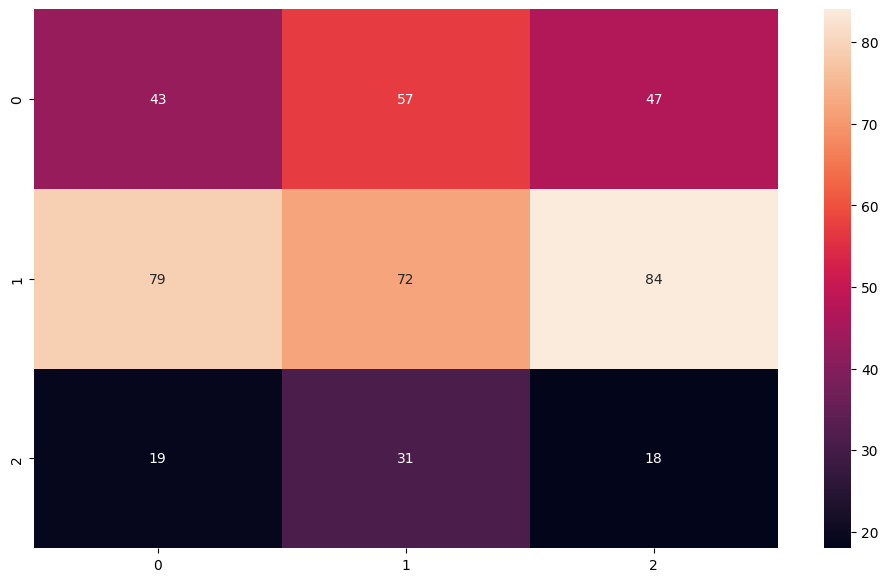

In [195]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

df_cm = pd.DataFrame(conf_matrix , index = [0,1,2],
                         columns = [0,1,2])
plt.figure(figsize = (12,7))
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
sn.heatmap(df_cm, annot=True)
plt.plot()

In [208]:
for i in range(len(train_dataset.img_labels)):
#     print(conf_matrix[i])
    precision = conf_matrix[i][i]/np.array(conf_matrix[i]).sum()
    recall = conf_matrix[i][i]/np.array([conf_matrix[0][i],conf_matrix[1][i],conf_matrix[2][i]]).sum()
    f1_score = 2*(precision*recall)/(precision+recall)
    print("Precision of class: ",train_dataset.img_labels[i]," is ",precision)
    print("Recall of class: ",train_dataset.img_labels[i]," is ",recall)    
    print("F1-Score of class: ",train_dataset.img_labels[i]," is ",f1_score)
    print()
    
    
accuracy = (conf_matrix[0][0]+conf_matrix[1][1]+conf_matrix[2][2])/np.array(conf_matrix).sum()
print("Accuracy",train_dataset.img_labels[i]," is ",accuracy)

Precision of class:  cat  is  0.2925170068027211
Recall of class:  cat  is  0.3049645390070922
F1-Score of class:  cat  is  0.2986111111111111

Precision of class:  dog  is  0.30638297872340425
Recall of class:  dog  is  0.45
F1-Score of class:  dog  is  0.3645569620253165

Precision of class:  snake  is  0.2647058823529412
Recall of class:  snake  is  0.12080536912751678
F1-Score of class:  snake  is  0.16589861751152077

Accuracy snake  is  0.29555555555555557


In [211]:
from torchsummary import summary


summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]          73,856
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
        MaxPool2d-14          [-1, 128,